This notebook is part of the $\omega radlib$  documentation: https://docs.wradlib.org.

Copyright (c) 2018, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Converting Reflectivity to Rainfall

Reflectivity (Z) and precipitation rate (R) can be related in form of a power law $Z=a \cdot R^b$. The parameters ``a`` and ``b`` depend on the type of precipitation (i.e. drop size distribution and water temperature). $\omega radlib$ provides a couple of functions that could be useful in this context.

In [1]:
import wradlib as wrl
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

The following example demonstrates the steps to convert from the common unit *dBZ* (decibel of the reflectivity factor *Z*) to rainfall intensity (in the unit of mm/h). This is an array of typical reflectivity values (**unit: dBZ**)

In [2]:
dBZ = np.array([20.0, 30.0, 40.0, 45.0, 50.0, 55.0])
print(dBZ)

[20. 30. 40. 45. 50. 55.]


Convert to reflectivity factor Z (**unit**: $mm^6/m^3$):

In [3]:
Z = wrl.trafo.idecibel(dBZ)
print(Z)

[1.00000000e+02 1.00000000e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05]


Convert to rainfall intensity (**unit: mm/h**) using the Marshall-Palmer Z(R) parameters:

In [4]:
R = wrl.zr.z_to_r(Z, a=200.0, b=1.6)
print(np.round(R, 2))

[ 0.65  2.73 11.53 23.68 48.62 99.85]


Convert to rainfall depth (**unit: mm**) assuming a rainfall duration of five minutes (i.e. 300 seconds)

In [5]:
depth = wrl.trafo.r_to_depth(R, 300)
print(np.round(depth, 2))

[0.05 0.23 0.96 1.97 4.05 8.32]


## An example with real radar data

The following example is based on observations of the DWD C-band radar on mount Feldberg (SW-Germany).
The figure shows a 15 minute accumulation of rainfall which was produced from three consecutive radar
scans at 5 minute intervals between 17:30 and 17:45 on June 8, 2008.

The radar data are read using [wradlib.io.read_dx](https://docs.wradlib.org/en/latest/generated/wradlib.io.radolan.read_dx.html) function which returns an array of dBZ values and a metadata dictionary (see also [Reading-DX-Data](../fileio/legacy/read_dx.ipynb#Reading-DX-Data)). The conversion is carried out the same way as in the example above. The plot is produced using
the function [wradlib.vis.plot](https://docs.wradlib.org/en/latest/generated/wradlib.vis.plot.html).

In [6]:
def read_data(dtimes):
    """Helper function to read raw data for a list of datetimes <dtimes>"""
    dalist = []
    for i, dtime in enumerate(dtimes):
        f = wrl.util.get_wradlib_data_file(
            "dx/raa00-dx_10908-{0}-fbg---bin.gz".format(dtime)
        )
        data, attrs = wrl.io.read_dx(f)
        radar_location = (8.003611, 47.873611, 1516.0)
        dtime = dt.datetime.strptime(dtime, "%y%m%d%H%M")
        dalist.append(
            wrl.georef.create_xarray_dataarray(
                data,
                r=np.arange(500, data.shape[1] * 1000 + 500, 1000),
                phi=attrs["azim"],
                theta=attrs["elev"],
                site=radar_location,
                sweep_mode="azimuth_surveillance",
            ).assign_coords(time=dtime)
        )
        ds = xr.concat(dalist, "time")
    return ds.assign_coords(elevation=ds.elevation.median("time"))

Read data from radar Feldberg for three consecutive 5 minute intervals and compute the accumulated rainfall depth.

In [7]:
# Read
dtimes = ["0806021735", "0806021740", "0806021745"]
dBZ = read_data(dtimes)
# Convert to rainfall intensity (mm/h)
Z = dBZ.wrl.trafo.idecibel()
R = Z.wrl.zr.z_to_r(a=200.0, b=1.6)
# Convert to rainfall depth (mm)
depth = R.wrl.trafo.r_to_depth(300)
# Accumulate 15 minute rainfall depth over all three 5 minute intervals
accum = depth.sum(dim="time")

Plot PPI of 15 minute rainfall depth

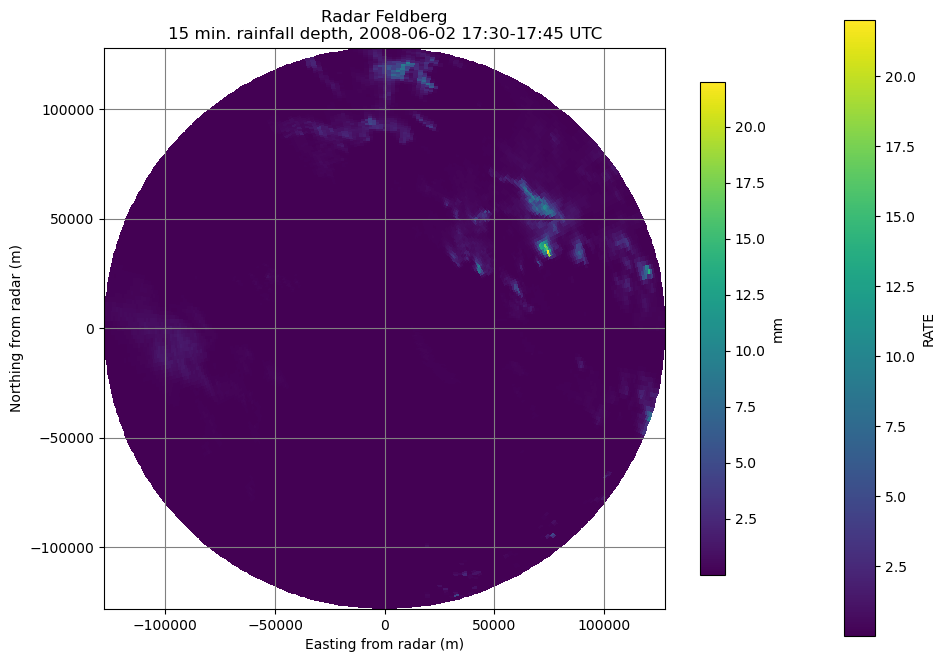

In [8]:
plt.figure(figsize=(10, 8))
da = accum.wrl.georef.georeference()
cf = da.wrl.vis.plot(cmap="viridis")
plt.xlabel("Easting from radar (m)")
plt.ylabel("Northing from radar (m)")
plt.title("Radar Feldberg\n15 min. rainfall depth, 2008-06-02 17:30-17:45 UTC")
cb = plt.colorbar(cf, shrink=0.8)
cb.set_label("mm")
plt.grid(color="grey")